In [1]:
from __future__ import print_function
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import torch
import torch.nn.functional as F

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


### Load the datasets

In [3]:
# load the training images and the semantic segmentation image
trainimage_path = '/home/xiaoyu/data_semantics/training/image_2/'
trainsemantic_path = '/home/xiaoyu/data_semantics/training/semantic_rgb/'

trainimages = os.listdir(trainimage_path)
trainsemantic = os.listdir(trainsemantic_path)
print("Training images numbers:"+str(len(trainimages)))
print("Training semantic segmentation Images numbers:"+str(len(trainsemantic)))
image_ex = trainimages[0]
print(image_ex)

Training images numbers:200
Training semantic segmentation Images numbers:200
000080_10.png


In [4]:
# image size
print("The training image size is:" + str(io.imread(os.path.join('/home/xiaoyu/data_semantics/training/image_2',image_ex)).shape))

The training image size is:(375, 1242, 3)


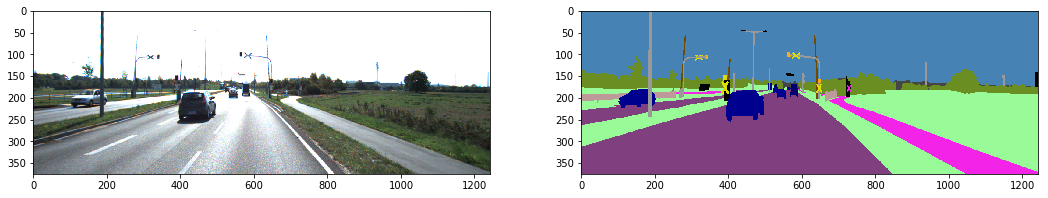

In [5]:
def show_semantic(image, semantic):
    """
    Show images with semantic segmentation
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The traing image semantic segmentation
    """
    plt.figure(figsize=(18, 3))
    plt.subplot(1,2,1)
    plt.imshow(image, aspect='auto')
    plt.subplot(1,2,2)
    plt.imshow(semantic, aspect='auto')
    plt.show()
    
# test the function

show_semantic(io.imread(os.path.join('/home/xiaoyu/data_semantics/training/image_2',image_ex)), io.imread(os.path.join('/home/xiaoyu/data_semantics/training/semantic_rgb/',image_ex)))

### Define a TrainDataset class which includes the training images and the semantic segmentation of these images

In [6]:
class TrainDatasetRGB(Dataset):
    """Training dataset with semantic segmentation on RGB"""
    def __init__(self, train_dir, semantic_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.train_dir = train_dir
        self.transform = transform
        self.semantic_dir = semantic_dir
        
    def __len__(self):
        return len(os.listdir(self.train_dir))
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.train_dir, os.listdir(self.train_dir)[idx])
        semantic_name = os.path.join(self.semantic_dir, os.listdir(self.semantic_dir)[idx])
        image = io.imread(img_name)
        semantic = io.imread(semantic_name)
        sample = {'image':image, 'semantic':semantic}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

0 (375, 1242, 3) (375, 1242, 3)


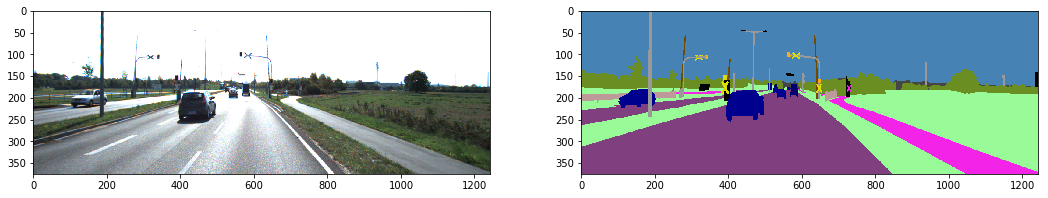

1 (375, 1242, 3) (375, 1242, 3)


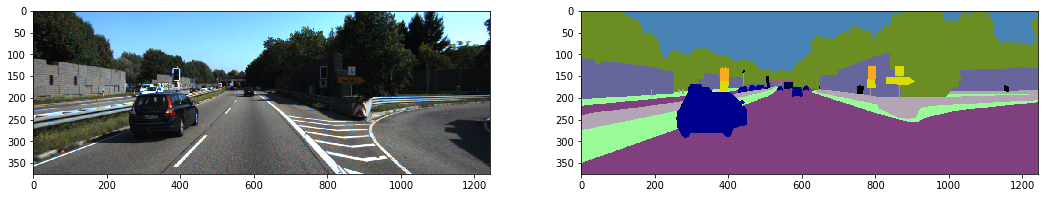

2 (375, 1242, 3) (375, 1242, 3)


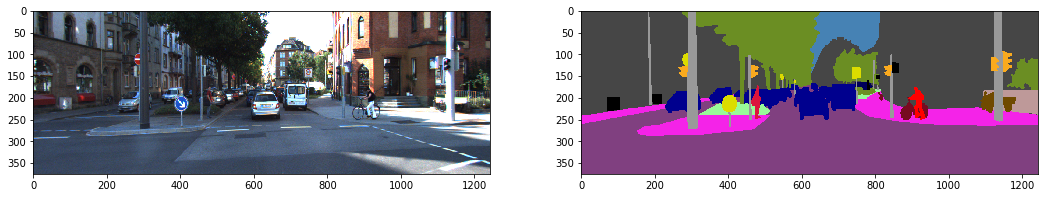

In [7]:
train_data = TrainDatasetRGB(train_dir='/home/xiaoyu/data_semantics/training/image_2/', 
                                semantic_dir ='/home/xiaoyu/data_semantics/training/semantic_rgb/')

for i in range(len(train_data)):
    sample = train_data[i]
    print(i, sample['image'].shape, sample['semantic'].shape)
    show_semantic(sample['image'],sample['semantic'])
    
    if i == 2:  
        break

In [8]:
class ToTensor(object):
    """Convert ndarrays in sample (both the original image 
    and the semantic image to Tensors"""
    
    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']
        
        #swap color axis because
        #numpy image: H x W x C
        #torch image: C x H x W
        image = image.transpose((2, 0, 1))
        semantic = semantic.transpose((2, 0 ,1))
        return {'image': torch.from_numpy(image),
                'semantic': torch.from_numpy(semantic)}

In [9]:
class Rescale(object):
    """Rescale the image and the semantic image in sample to a given size.
    
    Args:
        output_h(int): Desired output height, both for image and semantic image
        output_w(int): Desired output width, both for image and semantic image
    """
    
    def __init__(self, new_h, new_w):
        self.new_h = new_h
        self.new_w = new_w
    
    def __call__(self, sample):
        image, semantic = sample['image'], sample['semantic']
        
        img = transform.resize(image,(self.new_h, self.new_w))
        semantic = transform.resize(semantic,(self.new_h, self.new_w))
        
        return{'image': img, 'semantic': semantic}

        

/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<Figure size 432x288 with 0 Axes>

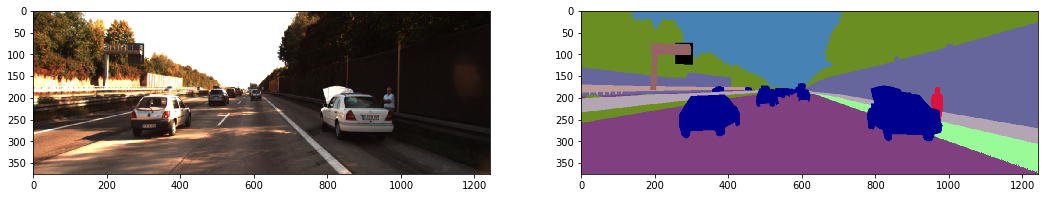

In [10]:
scale = Rescale(375,1242)
composed = transforms.Compose([Rescale(375,1242),ToTensor()])

fig = plt.figure()
sample = train_data[32]
transformed_sample = scale(sample)
show_semantic(**transformed_sample)

In [11]:
composed = transforms.Compose([Rescale(375,1242),ToTensor()])
transformed_dataset = TrainDatasetRGB(train_dir='/home/xiaoyu/data_semantics/training/image_2/', 
                                semantic_dir ='/home/xiaoyu/data_semantics/training/semantic_rgb/',
                               transform = composed
                               )

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['semantic'].size())
    
    if i == 3:
        break

print("Transformed_dataset is : " + str(type(transformed_dataset)))


0 torch.Size([3, 375, 1242]) torch.Size([3, 375, 1242])
1 torch.Size([3, 375, 1242]) torch.Size([3, 375, 1242])
2 torch.Size([3, 375, 1242]) torch.Size([3, 375, 1242])
3 torch.Size([3, 375, 1242]) torch.Size([3, 375, 1242])
Transformed_dataset is : <class '__main__.TrainDatasetRGB'>


In [12]:
dataloader = DataLoader(transformed_dataset, batch_size=1, 
                        shuffle = False, num_workers = 4)

# Helper function to show a batch
def show_semantic_batch(sample_batched):
    """Show original images and semantic images for a batch of samples"""
    images_batch, semantic_batch = \
            sample_batched['image'], sample_batched['semantic']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.figure(figsize=(18, 3))
    plt.imshow(grid.numpy().transpose((1,2,0)))
 

0 torch.Size([1, 3, 375, 1242]) torch.Size([1, 3, 375, 1242])
torch.float64
1 torch.Size([1, 3, 375, 1242]) torch.Size([1, 3, 375, 1242])
torch.float64
2 torch.Size([1, 3, 375, 1242]) torch.Size([1, 3, 375, 1242])
torch.float64
3 torch.Size([1, 3, 375, 1242]) torch.Size([1, 3, 375, 1242])
torch.float64


<Figure size 432x288 with 0 Axes>

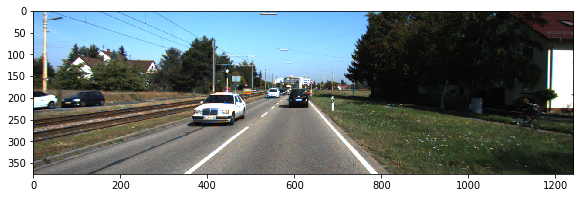

In [13]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['semantic'].size())
    print(sample_batched['image'].dtype)
    #Observe the 4th batch and stop
    if i_batch == 3:
        plt.figure()
        show_semantic_batch(sample_batched)
        break
    

### Define the Unet

In [14]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

In [15]:
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [16]:
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

In [17]:
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


In [18]:
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


In [19]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

#### Unet parameters

In [20]:
unet = UNet(3,1)
print(unet)
unet_params = list(unet.parameters())
print(len(unet_params))
print(unet_params[0].size()) # conv1's weight

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

In [21]:
unet = unet.cuda()

0 torch.Size([1, 3, 375, 1242]) torch.Size([1, 3, 375, 1242])


/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


tensor([[[[0.5958, 0.3625, 0.4030,  ..., 0.3459, 0.4018, 0.5562],
          [0.5565, 0.3805, 0.3945,  ..., 0.2997, 0.2163, 0.4796],
          [0.5048, 0.4081, 0.4783,  ..., 0.4598, 0.4231, 0.4889],
          ...,
          [0.5037, 0.4075, 0.4330,  ..., 0.4990, 0.4466, 0.5274],
          [0.5086, 0.4433, 0.4044,  ..., 0.4347, 0.4608, 0.4975],
          [0.4975, 0.4849, 0.5039,  ..., 0.5104, 0.5227, 0.5464]]]],
       device='cuda:0', grad_fn=<SigmoidBackward>)


<Figure size 432x288 with 0 Axes>

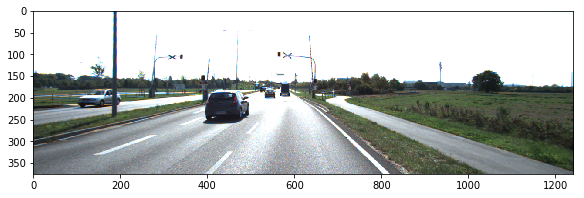

In [22]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['semantic'].size())
    out = unet(sample_batched['image'].cuda().float())
    #Observe the 4th batch and stop
    if i_batch == 0:
        plt.figure()
        show_semantic_batch(sample_batched)
        print(out)
        break

### Choose the criterion, learning rate, and batch size

In [23]:
torch.cuda.current_device()

0

In [24]:
criterion = nn.CrossEntropyLoss()
my_lr = 0.25
bs = 128

In [25]:
def eval_on_train_set():
    running_error = 0
    num_batches = 0
    
    for i in range(0,1000,bs):
        minibatch_data = train_data[i:i+bs]['image'].unsqueese(dim=1)
        minibatch_semantic = train_data[i:i+bs]['semantic'].unsqueese(dim=1)
        
        inputs = (minibatch_data - )

SyntaxError: invalid syntax (<ipython-input-25-fb172bc653f2>, line 9)